# PSD

* **author**: steeve.laquitaine@epfl.ch

* **Figure**: Figure 2O-Q

* **Execution duration:** : 10 mins for 10 min recordings

* **Method**: PSD for first 10 minutes of recording. We will analyse the first 10 minutes as PSD is stable across time (compared with 40 min).
    * `Horvath` (aligned with cortical column)
        * rat cortex S1
        * 128ch
        * 30.0kHz
        * Horvath in vivo probe 1:
            * duration: 3606.552 (~60 mins)
        * Horvath in vivo probe 2:
            * duration: 3688.668 secs (~61 mins)
        * Horvath in vivo probe 3:
            * duration: 3603.096 secs (~60 mins)  
        * "Spontaneous activity" (Only anesthetized condition)
    * `high-density (Horvath)` (aligned with cortical column)
        * run: 2023_10_18
        * rat cortex S1
        * 384ch 
        * 40.0kHz
        * 10 min
        * "Spontaneous activity" (Only anesthetized condition)
        * fitted gain and noise + fine tuned gain
        * Silico probe 1
            * duration: 1175.9988 secs (~28 min)
        * Silico probe 2   
            * duration: 1714.99825 secs (~19 min)
        * Silico probe 3: 
            * duration: 1763.9982 secs  (~29 min)
    * `Buccino`:
        * 10 min
    * Welch method
        * 1Hz resolution, Hann window
    * The quality of PSD estimation from FFT depends on a unique parameter, the number of signal samples, N. The largest the number of samples, 
    and the better the frequency resolution, $f_r$, of the PSD, given sampling frequency $f_s$

    $$f_r = f_s / N$$

    * We estimated all PSDs over the same number of recording samples, to allow for a fair comparison of PSDs which frequency resolution depends on the signal's sample size. Small sample size degrades the frequency resolution of the PSD compared to large sample size, potentially masking significant features.
    * To minimize computational cost, we show the PSDs estimated from the same sample sizes corresponding to about 5 min of recordings, which was the shortest period that best preserved the features observed in the PSD estimated from the entire recordings.
    * We also estimated the PSD for all experiments' first 20 minutes (the largest common duration) and the entire recordings (see Supplementary figure).

### Setup

1. Activate `spikeinterf..` venv

2. precompute data with: $ sbatch cluster/validation/main/marques/psd_buttw_noise_fitd_gain_ftd_10perc_less_raw_welch.sbatch (4m)

In [33]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import scipy
from sklearn.linear_model import LinearRegression
import copy

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config

matplotlib.rcParams['agg.path.chunksize'] = 10000


# SETUP PARAMETERS
SFREQ_V = 20000          # sampling frequency
SFREQ_S = 20000        # sampling frequency
SFREQ_B = 32000

# SETUP DATASET COMFIG
# vivo
data_conf_v, param_conf_h_v = get_config("vivo_horvath", "probe_2").values()
RAW_PATH_v = data_conf_v["probe_wiring"]["output"]
PREP_PATH_v = data_conf_v["preprocessing"]["output"]["trace_file_path"]

# silico 
data_conf_s, param_conf_s = get_config(
    "silico_horvath", "concatenated/probe_2"
).values()
RAW_PATH_s = data_conf_s["probe_wiring"]["output"]
PREP_PATH_s = data_conf_s["preprocessing"]["output"]["trace_file_path"]

# Buccino with fitted gain for layer 5
data_conf_b, _ = get_config("buccino_2020", "2020").values()
RAW_PATH_GAIN_FTD_B = data_conf_b["analyses"]["psd"]["10m"]["raw_gain_ftd"]
PREP_PATH_GAIN_FTD_B = data_conf_b["analyses"]["psd"]["10m"]["prep_gain_ftd"]


# FIGURE SETTINGS
#FIG_SIZE = (8.5, 4)
FIG_SIZE = (14, 4)
COLOR_VIVO = np.array([153,153,153]) / 255
COLOR_SILI = np.array([228, 26, 28]) / 255
COLOR_BUCCI = np.array([55,126,184]) / 255
FIT_BAND2 = np.array([152,78,163]) / 255
FIT_BAND3 = np.array([255,127,0]) / 255
BOX_ASPECT = 1                  # square fig
LG_FRAMEON = False              # no legend frame
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 30
plt.rcParams['lines.linewidth'] = 1.1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.8 * 1.3
plt.rcParams['ytick.major.width'] = 0.8 * 1.3
plt.rcParams['xtick.major.size'] = 3.5 * 2
plt.rcParams['xtick.minor.size'] = 2 * 2
plt.rcParams['ytick.major.size'] = 3.5 * 2
plt.rcParams['ytick.minor.size'] = 2 * 2

N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
YLIM = [1e-7, 1e8]
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-06-13 14:45:23,834 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-13 14:45:23,856 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-13 14:45:23,858 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-13 14:45:23,885 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-13 14:45:23,886 - root - utils.py - get_config - INFO - Reading experiment config.


2024-06-13 14:45:23,938 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Utils

In [34]:
def load_saved_traces_in_ctx():

    # vivo
    raw_traces_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/dataeng/1_vivo/horvath/probe_2/recording/traces_in_ctx_10m.npy"
    )
    prep_traces_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/preprocessed/1_vivo/horvath/probe_2/recording/traces_in_ctx_10m.npy"
    )

    # silico
    raw_traces_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/0_silico/horvath/concatenated_campaigns/probe2_hex0_rou04_pfr03_20Khz/dataeng/recording/traces_in_ctx_10m_noise_fitd_gain_ftd.npy"
    )
    prep_traces_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/0_silico/horvath/concatenated_campaigns/probe2_hex0_rou04_pfr03_20Khz/preprocessed/traces_in_ctx_10m_noise_fitd_gain_ftd.npy"
    )
    return raw_traces_vivo, prep_traces_vivo, raw_traces_sili, prep_traces_sili


def load_psd_results():

    # save sili
    out_raw_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/0_silico/horvath/concatenated_campaigns/probe2_hex0_rou04_pfr03_20Khz/postpro/realism/lfp/full_raw_power_welch_10m_gain_ftd.npy",
        allow_pickle=True,
    )
    out_raw_sili = out_raw_sili.item()

    out_prep_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/0_silico/horvath/concatenated_campaigns/probe2_hex0_rou04_pfr03_20Khz/postpro/realism/lfp/full_prep_buttw_power_welch_10m_gain_ftd.npy",
        allow_pickle=True,
    )
    out_prep_sili = out_prep_sili.item()

    # save vivo
    out_raw_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/postprocessing/vivo/horvath/probe_2/postpro/realism/lfp/full_raw_power_welch_10m.npy",
        allow_pickle=True,
    )
    out_raw_vivo = out_raw_vivo.item()

    out_prep_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/postprocessing/vivo/horvath/probe_2/postpro/realism/lfp/full_prep_buttw_power_welch_10m.npy",
        allow_pickle=True,
    )
    out_prep_vivo = out_prep_vivo.item()
    return out_raw_sili, out_prep_sili, out_raw_vivo, out_prep_vivo


def get_psd_plot_mean_and_ci(
    out_raw_vivo, out_raw_sili, out_raw_b, out_prep_vivo, out_prep_sili, out_prep_b
):
    """calculate PSD means and confidence intervals"""
    # (11s) average over sites
    psd_mean_raw_vivo = np.median(out_raw_vivo["power"], axis=0)
    psd_mean_raw_sili = np.median(out_raw_sili["power"], axis=0)
    psd_mean_raw_b = np.median(out_raw_b["power"], axis=0)
    psd_mean_prep_vivo = np.median(out_prep_vivo["power"], axis=0)
    psd_mean_prep_sili = np.median(out_prep_sili["power"], axis=0)
    psd_mean_prep_b = np.median(out_prep_b["power"], axis=0)

    # confidence intervals
    # vivo
    n_samples = out_raw_vivo["power"].shape[0]
    ci_raw_vivo = 1.96 * np.std(out_raw_vivo["power"], axis=0) / np.sqrt(n_samples)
    ci_prep_vivo = 1.96 * np.std(out_prep_vivo["power"], axis=0) / np.sqrt(n_samples)
    # sili
    n_samples = out_raw_sili["power"].shape[0]
    ci_raw_sili = 1.96 * np.std(out_raw_sili["power"], axis=0) / np.sqrt(n_samples)
    ci_prep_sili = 1.96 * np.std(out_prep_sili["power"], axis=0) / np.sqrt(n_samples)
    # buccino
    n_samples = out_raw_b["power"].shape[0]
    ci_raw_b = 1.96 * np.std(out_raw_b["power"], axis=0) / np.sqrt(n_samples)
    ci_prep_b = 1.96 * np.std(out_prep_b["power"], axis=0) / np.sqrt(n_samples)

    return (
        psd_mean_raw_vivo,
        psd_mean_raw_sili,
        psd_mean_raw_b,
        psd_mean_prep_vivo,
        psd_mean_prep_sili,
        psd_mean_prep_b,
        ci_raw_vivo,
        ci_prep_vivo,
        ci_raw_sili,
        ci_prep_sili,
        ci_raw_b,
        ci_prep_b,
    )


def get_psd_plot_mean_and_ci_for_layer(
    layer: str,
    lyrs_v: list,
    lyrs_s: list,
    out_raw_vivo: dict,
    out_raw_sili: dict,
    out_prep_vivo: dict,
    out_prep_sili: dict,
):
    # get sites in layer
    power_v = out_raw_vivo["power"][lyrs_v == layer, :]
    power_s = out_raw_sili["power"][lyrs_s == layer, :]
    pre_power_v = out_prep_vivo["power"][lyrs_v == layer, :]
    pre_power_s = out_prep_sili["power"][lyrs_s == layer, :]

    # (11s) average over sites
    psd_mean_raw_vivo = np.median(power_v, axis=0)
    psd_mean_raw_sili = np.median(power_s, axis=0)
    psd_mean_prep_vivo = np.median(pre_power_v, axis=0)
    psd_mean_prep_sili = np.median(pre_power_s, axis=0)

    # confidence intervals
    # vivo
    n_samples = power_v.shape[0]
    ci_raw_vivo = 1.96 * np.std(power_v, axis=0) / np.sqrt(n_samples)
    ci_prep_vivo = 1.96 * np.std(pre_power_v, axis=0) / np.sqrt(n_samples)

    # sili
    n_samples = power_s.shape[0]
    ci_raw_sili = 1.96 * np.std(power_s, axis=0) / np.sqrt(n_samples)
    ci_prep_sili = 1.96 * np.std(pre_power_s, axis=0) / np.sqrt(n_samples)

    return (
        psd_mean_raw_vivo,
        psd_mean_raw_sili,
        psd_mean_prep_vivo,
        psd_mean_prep_sili,
        ci_raw_vivo,
        ci_raw_sili,
        ci_prep_vivo,
        ci_prep_sili,
        out_raw_vivo["freq"],
        out_raw_sili["freq"],
        out_prep_vivo["freq"],
        out_prep_sili["freq"],
    )


def get_psd_plot_mean_and_ci_for_layer_5(
    lyrs_v: list,
    lyrs_s: list,
    out_raw_v: dict,
    out_raw_s: dict,
    out_raw_b: dict,
    out_prep_v: dict,
    out_prep_s: dict,
    out_prep_b: dict,
):

    # get sites in layer
    power_v = out_raw_v["power"][lyrs_v == "L5", :]
    power_s = out_raw_s["power"][lyrs_s == "L5", :]
    power_b = out_raw_b["power"]
    pre_power_v = out_prep_v["power"][lyrs_v == "L5", :]
    pre_power_s = out_prep_s["power"][lyrs_s == "L5", :]
    pre_power_b = out_prep_b["power"]

    # (11s) average over sites
    psd_mean_raw_vivo = np.median(power_v, axis=0)
    psd_mean_raw_sili = np.median(power_s, axis=0)
    psd_mean_raw_b = np.median(power_b, axis=0)
    psd_mean_prep_vivo = np.median(pre_power_v, axis=0)
    psd_mean_prep_sili = np.median(pre_power_s, axis=0)
    psd_mean_prep_b = np.median(pre_power_b, axis=0)

    # confidence intervals
    # vivo
    n_samples = power_v.shape[0]
    ci_raw_vivo = 1.96 * np.std(power_v, axis=0) / np.sqrt(n_samples)
    ci_prep_vivo = 1.96 * np.std(pre_power_v, axis=0) / np.sqrt(n_samples)

    # sili
    n_samples = power_s.shape[0]
    ci_raw_sili = 1.96 * np.std(power_s, axis=0) / np.sqrt(n_samples)
    ci_prep_sili = 1.96 * np.std(pre_power_s, axis=0) / np.sqrt(n_samples)

    # buccino
    n_samples = power_b.shape[0]
    ci_raw_b = 1.96 * np.std(power_b, axis=0) / np.sqrt(n_samples)
    ci_prep_b = 1.96 * np.std(pre_power_b, axis=0) / np.sqrt(n_samples)

    return (
        psd_mean_raw_vivo,
        psd_mean_raw_sili,
        psd_mean_raw_b,
        psd_mean_prep_vivo,
        psd_mean_prep_sili,
        psd_mean_prep_b,
        ci_raw_vivo,
        ci_raw_sili,
        ci_raw_b,
        ci_prep_vivo,
        ci_prep_sili,
        ci_prep_b,
        out_raw_v["freq"],
        out_raw_s["freq"],
        out_raw_b["freq"],
        out_prep_v["freq"],
        out_prep_s["freq"],
        out_prep_b["freq"],
    )


def plot_for_layer(
    psd_mean_raw_vivo,
    psd_mean_raw_sili,
    psd_mean_prep_vivo,
    psd_mean_prep_sili,
    ci_raw_vivo,
    ci_prep_vivo,
    ci_raw_sili,
    ci_prep_sili,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
    site_layers_vivo,
    site_layers_sili,
    layer,
    ylim_r,
    ylim_p,
):
    """plot power spectrum density for the
    specified layer

    Args:
        layer (str): layer "L1", "L2_3", "L4", "L5", "L6"
        site_layers_sili (list): layers of each in silico sites
        site_layers_vivo (list): layers of each in vivo sites
        out_raw_vivo (dict): _description_
        out_raw_sili (dict): _description_
    """

    N_MAJOR_TICKS = 4
    SIZE = 3
    ALPHA = 0.7
    fig, axes = plt.subplots(1, 3, figsize=FIG_SIZE)

    # Raw panel --------------------------------

    # VIVO
    axes[0].plot(
        freq_raw_v,
        psd_mean_raw_vivo,
        linestyle="none",
        marker="o",
        markersize=SIZE,
        color=COLOR_VIVO,
        label="vivo",
        rasterized=True,  # cheaper
    )
    axes[0].plot(
        freq_raw_s,
        psd_mean_raw_sili,
        linestyle="none",
        marker="o",
        markersize=SIZE,
        color=COLOR_SILI,
        label="sili",
        rasterized=True,  # cheaper
    )

    # confidence interval
    axes[0].fill_between(
        freq_raw_v,
        (psd_mean_raw_vivo - ci_raw_vivo),
        (psd_mean_raw_vivo + ci_raw_vivo),
        color=COLOR_VIVO,
        linewidth=0,
        alpha=ALPHA,
        rasterized=True,
    )
    axes[0].fill_between(
        freq_raw_s,
        (psd_mean_raw_sili - ci_raw_sili),
        (psd_mean_raw_sili + ci_raw_sili),
        color=COLOR_SILI,
        linewidth=0,
        alpha=ALPHA,
        rasterized=True,
    )

    # legend
    axes[0].set_xlabel("Frequency (Hz)")
    axes[0].set_xlabel("")
    axes[0].set_xscale("log")
    axes[0].spines[["right", "top"]].set_visible(False)
    axes[0].set_ylim(ylim_r)
    axes[0].set_xlim([-1, SFREQ_S / 2])
    axes[0].tick_params(axis="x", which="minor", colors="black")
    axes[0].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[0].tick_params(which="both")
    axes[0].xaxis.set_major_locator(locmaj)
    axes[0].xaxis.set_minor_locator(locmin)
    axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    # disconnect axes (R style)
    axes[0].spines["bottom"].set_position(("axes", -0.05))
    axes[0].yaxis.set_ticks_position("left")
    axes[0].spines["left"].set_position(("axes", -0.05))
    axes[0].set_ylim(ylim_r)
    axes[0].set_xlim([0, SFREQ_S / 2])

    # Fit panel ************************************************************

    # get sites in layer
    out_raw_vivo2 = copy.copy(out_raw_vivo)
    out_raw_sili2 = copy.copy(out_raw_sili)
    out_raw_vivo2["power"] = out_raw_vivo2["power"][site_layers_vivo == layer, :]
    out_raw_sili2["power"] = out_raw_sili2["power"][site_layers_sili == layer, :]

    # plot
    plot_fits_all(axes[1], out_raw_vivo2, out_raw_sili2, pm)

    # Preprocessing ************************************************************

    # VIVO
    axes[2].plot(
        freq_prep_v,
        psd_mean_prep_vivo,
        linestyle="none",
        marker="o",
        markersize=SIZE,
        color=COLOR_VIVO,
        label="vivo",
        rasterized=True,  # cheaper
    )
    axes[2].plot(
        freq_prep_s,
        psd_mean_prep_sili,
        color=COLOR_SILI,
        label="silico",
        marker="o",
        markersize=SIZE,
        rasterized=True,  # cheaper
    )

    # legend
    # axes[1].set_xlabel("Frequency (Hz)")
    axes[2].set_xlabel("")
    axes[2].set_xscale("log")
    axes[2].spines[["right", "top"]].set_visible(False)
    axes[2].set_ylim(ylim_p)
    axes[2].set_xlim([-1, SFREQ_S / 2])
    axes[2].tick_params(axis="x", which="minor", colors="black")
    axes[2].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[2].tick_params(which="both")
    axes[2].xaxis.set_major_locator(locmaj)
    axes[2].xaxis.set_minor_locator(locmin)
    axes[2].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    # disconnect axes (R style)
    axes[2].spines["bottom"].set_position(("axes", -0.05))
    axes[2].yaxis.set_ticks_position("left")
    axes[2].spines["left"].set_position(("axes", -0.05))
    axes[2].set_ylim(ylim_p)
    axes[2].set_xlim([0, SFREQ_S / 2])

    fig.tight_layout(**tight_layout_cfg)
    return axes


def plot_for_layer_5(
    psd_mean_raw_vivo,
    psd_mean_raw_sili,
    psd_mean_raw_b,
    psd_mean_prep_vivo,
    psd_mean_prep_sili,
    psd_mean_prep_b,
    ci_raw_vivo,
    ci_raw_sili,
    ci_raw_b,
    ci_prep_vivo,
    ci_prep_sili,
    ci_prep_b,
    freq_raw_v,
    freq_raw_s,
    freq_raw_b,
    freq_prep_v,
    freq_prep_s,
    freq_prep_b,
    out_raw_vivo,
    out_raw_sili,
    out_raw_b,
    site_layers_vivo,
    site_layers_sili,
    ylim_r,
    ylim_p,
):
    """plot power spectrum density for the
    specified layer

    Args:
        layer (str): layer "L1", "L2_3", "L4", "L5", "L6"
        site_layers_sili (list): layers of each in silico sites
        site_layers_vivo (list): layers of each in vivo sites
        out_raw_vivo (dict): _description_
        out_raw_sili (dict): _description_
    """

    N_MAJOR_TICKS = 4
    SIZE = 3
    ALPHA = 0.7
    pm = {
        "linestyle": "none",
        "marker": "o",
        "markersize": SIZE,
        "rasterized": True,
    }
    fig, axes = plt.subplots(1, 3, figsize=FIG_SIZE)

    # Raw
    axes[0].plot(freq_raw_v, psd_mean_raw_vivo, color=COLOR_VIVO, label="vivo", **pm)
    axes[0].plot(freq_raw_b, psd_mean_raw_b, color=COLOR_BUCCI, label="buccino", **pm)
    axes[0].plot(freq_raw_s, psd_mean_raw_sili, color=COLOR_SILI, label="sili", **pm)
    # confidence interval
    axes[0].fill_between(
        freq_raw_v,
        (psd_mean_raw_vivo - ci_raw_vivo),
        (psd_mean_raw_vivo + ci_raw_vivo),
        color=COLOR_VIVO,
        linewidth=0,
        alpha=ALPHA,
        rasterized=True,
    )
    axes[0].fill_between(
        freq_raw_b,
        (psd_mean_raw_b - ci_raw_b),
        (psd_mean_raw_b + ci_raw_b),
        color=COLOR_BUCCI,
        linewidth=0,
        alpha=ALPHA,
        rasterized=True,
    )
    axes[0].fill_between(
        freq_raw_s,
        (psd_mean_raw_sili - ci_raw_sili),
        (psd_mean_raw_sili + ci_raw_sili),
        color=COLOR_SILI,
        linewidth=0,
        alpha=ALPHA,
        rasterized=True,
    )

    # legend
    axes[0].set_xlabel("Frequency (Hz)")
    axes[0].set_xlabel("")
    axes[0].set_xscale("log")
    axes[0].spines[["right", "top"]].set_visible(False)
    axes[0].set_ylim(ylim_r)
    axes[0].set_xlim([-1, SFREQ_S / 2])
    axes[0].tick_params(axis="x", which="minor", colors="black")
    axes[0].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[0].tick_params(which="both")
    axes[0].xaxis.set_major_locator(locmaj)
    axes[0].xaxis.set_minor_locator(locmin)
    axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    # disconnect axes (R style)
    axes[0].spines["bottom"].set_position(("axes", -0.05))
    axes[0].yaxis.set_ticks_position("left")
    axes[0].spines["left"].set_position(("axes", -0.05))
    axes[0].set_ylim(ylim_r)
    axes[0].set_xlim([0, SFREQ_S / 2])

    # Fit panel ************************************************************

    # get sites in layer
    out_raw_vivo2 = copy.copy(out_raw_vivo)
    out_raw_sili2 = copy.copy(out_raw_sili)
    out_raw_vivo2["power"] = out_raw_vivo2["power"][site_layers_vivo == "L5", :]
    out_raw_sili2["power"] = out_raw_sili2["power"][site_layers_sili == "L5", :]

    # plot
    plot_fits_all_for_layer_5(axes[1], out_raw_vivo2, out_raw_sili2, out_raw_b, pm)

    # Preprocessing ************************************************************

    axes[2].plot(
        freq_prep_v,
        psd_mean_prep_vivo,
        linestyle="none",
        marker="o",
        markersize=SIZE,
        color=COLOR_VIVO,
        label="vivo",
        rasterized=True,  # cheaper
    )
    axes[2].plot(
        freq_prep_b,
        psd_mean_prep_b,
        color=COLOR_BUCCI,
        label="Buccino",
        marker="o",
        markersize=SIZE,
        rasterized=True,  # cheaper
    )
    axes[2].plot(
        freq_prep_s,
        psd_mean_prep_sili,
        color=COLOR_SILI,
        label="silico",
        marker="o",
        markersize=SIZE,
        rasterized=True,  # cheaper
    )

    # confidence interval
    axes[2].fill_between(
        freq_prep_v,
        (psd_mean_prep_vivo - ci_prep_vivo),
        (psd_mean_prep_vivo + ci_prep_vivo),
        color=COLOR_VIVO,
        linewidth=0,
        alpha=ALPHA,
        rasterized=True,
    )
    axes[2].fill_between(
        freq_prep_b,
        (psd_mean_prep_b - ci_prep_b),
        (psd_mean_prep_b + ci_prep_b),
        color=COLOR_BUCCI,
        linewidth=0,
        alpha=ALPHA,
        rasterized=True,
    )
    axes[2].fill_between(
        freq_prep_s,
        (psd_mean_prep_sili - ci_prep_sili),
        (psd_mean_prep_sili + ci_prep_sili),
        color=COLOR_SILI,
        linewidth=0,
        alpha=ALPHA,
        rasterized=True,
    )

    # legend
    # axes[1].set_xlabel("Frequency (Hz)")
    axes[2].set_xlabel("")
    axes[2].set_xscale("log")
    axes[2].spines[["right", "top"]].set_visible(False)
    axes[2].set_ylim(ylim_p)

    axes[2].set_xlim([-1, SFREQ_S / 2])
    axes[2].tick_params(axis="x", which="minor", colors="black")
    axes[2].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[2].tick_params(which="both")
    axes[2].xaxis.set_major_locator(locmaj)
    axes[2].xaxis.set_minor_locator(locmin)
    axes[2].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    # disconnect axes (R style)
    axes[2].spines["bottom"].set_position(("axes", -0.05))
    axes[2].yaxis.set_ticks_position("left")
    axes[2].spines["left"].set_position(("axes", -0.05))
    axes[2].set_ylim(ylim_p)
    axes[2].set_xlim([0, SFREQ_S / 2])

    fig.tight_layout(**tight_layout_cfg)

    return axes


def eval_freq_scaling(out_raw_vivo: dict, freq_range=tuple):

    # count sites
    n_sites = out_raw_vivo["power"].shape[0]

    log_powers = []
    alphas = []
    intercepts = []

    for s_i in range(n_sites):

        # get frequencies with non-inf log power
        # and for slow freq 0 to 20 Hz [Bedard, 2006] with
        # alpha = 1
        log_freq = np.array([np.log10(out_raw_vivo["freq"])]).T
        good_ix = np.where(
            (np.log10(out_raw_vivo["freq"]) != -np.inf)
            & (out_raw_vivo["freq"] > freq_range[0])
            & (out_raw_vivo["freq"] <= freq_range[1])
        )[0]
        log_freq = log_freq[good_ix]

        # get log power
        log_power = np.log10(out_raw_vivo["power"][s_i, :])[good_ix]

        # calculate scaling factor (coef) alpha
        reg = LinearRegression().fit(log_freq, log_power)

        # store
        alphas.append(reg.coef_[0])
        intercepts.append(reg.intercept_)
        log_powers.append(log_power)

    # report stats
    print("mean alpha:", np.mean(alphas))
    print("std alpha:", np.std(alphas))
    print("n=", n_sites)
    return alphas, log_powers, log_freq, intercepts


def get_log_freq_and_powers(out_raw_vivo: dict):
    """get log frequencies and powers

    Args:
        out_raw_vivo (dict): _description_

    Returns:
        _type_: _description_
    """
    # count sites
    n_sites = out_raw_vivo["power"].shape[0]
    log_powers = []

    for s_i in range(n_sites):

        # get frequencies with non-inf log power
        log_freq = np.array([np.log10(out_raw_vivo["freq"])]).T
        good_ix = np.where(np.log10(out_raw_vivo["freq"]) != -np.inf)[0]
        log_freq = log_freq[good_ix]

        # get log power
        log_power = np.log10(out_raw_vivo["power"][s_i, :])[good_ix]

        # store
        log_powers.append(log_power)

    # report stats
    return log_powers, log_freq


def plot_fits_all(axis, out_raw_vivo, out_raw_sili, pm: dict):
    """_summary_

    first band: 0-70Hz
    2nd band: 300 - Nyquist

    silico:
        first band: 0-70Hz
        2nd band: 70 - 2000
        2nd band: 2500 - 200Nyquist

    Args:
        axis (_type_): _description_
        out_raw_vivo (_type_): _description_
        out_raw_sili (_type_): _description_
        pm (dict): _description_
    """
    LINEW = 6
    LINES = ":"

    # print("\nVIVO\n")
    # plot all frequencies
    log_powers_all, log_freq_all = get_log_freq_and_powers(out_raw_vivo)
    axis.plot(
        10**log_freq_all,
        10 ** np.array(log_powers_all).mean(axis=0),
        color=COLOR_VIVO,
        **pm
    )

    # 0-70 Hz band
    alphas, _, log_freq, interc = eval_freq_scaling(out_raw_vivo, freq_range=(0, 90))
    axis.plot(
        10**log_freq,
        10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
        LINES,
        linewidth=LINEW,
        color="k",
    )

    # 300 - 15000 Hz band
    # alphas, _, log_freq, interc = eval_freq_scaling(
    #     out_raw_vivo, freq_range=(300, SFREQ_V / 2)
    # )
    alphas, _, log_freq, interc = eval_freq_scaling(
        out_raw_vivo, freq_range=(110, SFREQ_V / 2)
    )
    axis.plot(
        10**log_freq,
        10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
        LINES,
        linewidth=LINEW,
        color=FIT_BAND2,
    )

    print("\nSILICO\n")

    log_powers_all, log_freq_all = get_log_freq_and_powers(out_raw_sili)
    axis.plot(
        10**log_freq_all,
        10 ** np.array(log_powers_all).mean(axis=0),
        color=COLOR_SILI,
        **pm
    )

    # 0-70 Hz
    alphas, _, log_freq, interc = eval_freq_scaling(out_raw_sili, freq_range=(0, 90))
    axis.plot(
        10**log_freq,
        10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
        LINES,
        linewidth=LINEW,
        color="k",
    )

    # 70-1,000 Hz
    alphas, _, log_freq, interc = eval_freq_scaling(out_raw_sili, freq_range=(110, 900))
    axis.plot(
        10**log_freq,
        10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
        LINES,
        linewidth=LINEW,
        color=FIT_BAND2,
    )

    # 1100-Nyquist Hz
    alphas, _, log_freq, interc = eval_freq_scaling(
        out_raw_sili, freq_range=(1100, SFREQ_S / 2)
    )
    axis.plot(
        10**log_freq,
        10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
        LINES,
        linewidth=LINEW,
        color=FIT_BAND3,
    )
    axis.set_xscale("log")
    axis.set_yscale("log")

    # legend
    axis.spines[["right", "top"]].set_visible(False)
    axis.legend(**legend_cfg)

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axis.tick_params(which="both")
    axis.xaxis.set_major_locator(locmaj)
    axis.xaxis.set_minor_locator(locmin)
    axis.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    # disconnect x,y axes
    axis.spines["bottom"].set_position(("axes", -0.05))
    axis.yaxis.set_ticks_position("left")
    axis.spines["left"].set_position(("axes", -0.05))


def plot_fits_all_for_layer_5(axis, out_raw_vivo, out_raw_sili, out_raw_b, pm: dict):

    LINEW = 6
    LINES = ":"

    # plot all frequencies
    log_powers_all, log_freq_all = get_log_freq_and_powers(out_raw_vivo)
    axis.plot(
        10**log_freq_all,
        10 ** np.array(log_powers_all).mean(axis=0),
        color=COLOR_VIVO,
        **pm
    )

    # 0-20 Hz band
    alphas, _, log_freq, interc = eval_freq_scaling(out_raw_vivo, freq_range=(0, 70))
    axis.plot(
        10**log_freq,
        10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
        LINES,
        linewidth=LINEW,
        color="k",
    )

    # 300 - 15000 Hz band
    alphas, _, log_freq, interc = eval_freq_scaling(
        out_raw_vivo, freq_range=(300, SFREQ_V / 2)
    )
    axis.plot(
        10**log_freq,
        10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
        LINES,
        linewidth=LINEW,
        color=FIT_BAND2,
    )

    # SILICO ************************

    log_powers_all, log_freq_all = get_log_freq_and_powers(out_raw_sili)
    axis.plot(
        10**log_freq_all,
        10 ** np.array(log_powers_all).mean(axis=0),
        color=COLOR_SILI,
        **pm
    )

    # 0-20 Hz
    alphas, _, log_freq, interc = eval_freq_scaling(out_raw_sili, freq_range=(0, 70))
    axis.plot(
        10**log_freq,
        10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
        LINES,
        linewidth=LINEW,
        color="k",
    )

    # 20-65 Hz
    alphas, _, log_freq, interc = eval_freq_scaling(out_raw_sili, freq_range=(70, 2000))
    axis.plot(
        10**log_freq,
        10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
        LINES,
        linewidth=LINEW,
        color=FIT_BAND2,
    )

    # 300-4000 Hz
    alphas, _, log_freq, interc = eval_freq_scaling(
        out_raw_sili, freq_range=(2500, SFREQ_S / 2)
    )
    axis.plot(
        10**log_freq,
        10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
        LINES,
        linewidth=LINEW,
        color=FIT_BAND3,
    )

    # BUCCINO  ************************

    # plot all frequencies
    log_powers_all, log_freq_all = get_log_freq_and_powers(out_raw_b)
    axis.plot(
        10**log_freq_all,
        10 ** np.array(log_powers_all).mean(axis=0),
        color=COLOR_BUCCI,
        **pm
    )

    # 0-20 Hz band
    alphas, _, log_freq, interc = eval_freq_scaling(out_raw_b, freq_range=(0, 70))
    axis.plot(
        10**log_freq,
        10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
        LINES,
        linewidth=LINEW,
        color="k",
    )

    # 300 - 15000 Hz band
    alphas, _, log_freq, interc = eval_freq_scaling(
        out_raw_b, freq_range=(300, SFREQ_B / 2)
    )
    axis.plot(
        10**log_freq,
        10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
        LINES,
        linewidth=LINEW,
        color=FIT_BAND2,
    )

    axis.set_xscale("log")
    axis.set_yscale("log")

    # legend
    axis.spines[["right", "top"]].set_visible(False)
    axis.legend(**legend_cfg)

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axis.tick_params(which="both")
    axis.xaxis.set_major_locator(locmaj)
    axis.xaxis.set_minor_locator(locmin)
    axis.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    # disconnect x,y axes
    axis.spines["bottom"].set_position(("axes", -0.05))
    axis.yaxis.set_ticks_position("left")
    axis.spines["left"].set_position(("axes", -0.05))

### (1s)Load dataset

* select first 10 min for speed

In [35]:
# Load traces
# load raw traces
RawV = si.load_extractor(RAW_PATH_v)
RawS = si.load_extractor(RAW_PATH_s)

# load preprocessed traces
PrepV = si.load_extractor(PREP_PATH_v)
PrepS = si.load_extractor(PREP_PATH_s)

# select first 10 minutes
RawV = RawV.frame_slice(start_frame=0, end_frame=SFREQ_V * 10 * 60)
PrepV = PrepV.frame_slice(start_frame=0, end_frame=SFREQ_V * 10 * 60)
RawS = RawS.frame_slice(start_frame=0, end_frame=SFREQ_S * 10 * 60)
PrepS = PrepS.frame_slice(start_frame=0, end_frame=SFREQ_S * 10 * 60)

# sanity check
assert RawS.get_total_duration() == 10 * 60, "not 10 min"
assert RawV.get_total_duration() == 10 * 60, "not 10 min"

### Validate amplitude

#### (1s)Keep cortical sites

In [36]:
# Keep traces from good sites (in cortex)

# silico
layers = ["L1", "L2_3", "L4", "L5", "L6"]
site_layers_sili = RawS.get_property("layers")
site_layers_sili = [
    "L2_3" if l_i == "L2" or l_i == "L3" else l_i for l_i in site_layers_sili
]
IN_CTX = np.isin(site_layers_sili, layers)
sites_sili = np.where(IN_CTX)[0]

# vivo
site_layers_vivo = RawV.get_property("layers")
IN_CTX = np.isin(site_layers_vivo, layers)
sites_vivo = np.where(IN_CTX)[0]

# keep only the layers
site_layers_sili = np.array(site_layers_sili)[sites_sili]
site_layers_vivo = np.array(site_layers_vivo)[sites_vivo]

#### (20s)Load traces and PSD in ctx

In [37]:
# load traces and PSD Marques
raw_traces_vivo, prep_traces_vivo, raw_traces_sili, prep_traces_sili = (
    load_saved_traces_in_ctx()
)
out_raw_sili, out_prep_sili, out_raw_vivo, out_prep_vivo = load_psd_results()

# load PSD Buccino (l5)
out_raw_b = np.load(RAW_PATH_GAIN_FTD_B, allow_pickle=True).item()
out_prep_b = np.load(PREP_PATH_GAIN_FTD_B, allow_pickle=True).item()

# unit-test
assert out_raw_vivo["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert out_raw_sili["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert out_raw_b["freq"][1] == 1.0, "psd resolution should be 1Hz"

#### Normalize

In [46]:
out_raw_sili["power"] = (
    out_raw_sili["power"] / out_raw_sili["power"].sum(axis=1)[:, None]
)
out_raw_vivo["power"] = (
    out_raw_vivo["power"] / out_raw_vivo["power"].sum(axis=1)[:, None]
)
out_prep_sili["power"] = (
    out_prep_sili["power"] / out_prep_sili["power"].sum(axis=1)[:, None]
)
out_prep_vivo["power"] = (
    out_prep_vivo["power"] / out_prep_vivo["power"].sum(axis=1)[:, None]
)
out_raw_b["power"] = out_raw_b["power"] / out_raw_b["power"].sum(axis=1)[:, None]
out_prep_b["power"] = out_prep_b["power"] / out_prep_b["power"].sum(axis=1)[:, None]

#### (2m) Plot column

The PSD is averaged over sites by layer. We used the median of the mean due to the small number of sites per layer.

#### Mann Whitney stats

* null hypothesis: the biophysical model and in vivo power spectra are the same, below 100 Hz.
* method: we used Mann Whitney to compare in vivo and simulated psd in rolling windows of size 5.

In [7]:
# compare biophysical model with in vivo PSD
# # find indices of 100 Hz
ix_100_hz_vivo = np.where(out_raw_vivo["freq"] == 100)[0][0]
ix_100_hz_sili = np.where(out_raw_vivo["freq"] == 100)[0][0]


def rolling_mw_test(sample_x, sample_y, window_size: int = 5):
    results = []
    pvalues = []
    for i in range(sample_x.shape[1] - window_size + 1):
        result = scipy.stats.mannwhitneyu(
            sample_x[:, i : i + window_size].flatten(),
            sample_y[:, i : i + window_size].flatten(),
        )
        # store results
        results.append(result)
        pvalues.append(result.pvalue)
    return (np.array(pvalues), results)


window_size = 5

# stats raw
pvalues_raw, results_raw = rolling_mw_test(
    out_raw_vivo["power"], out_raw_sili["power"], 5
)

# stats preprocessed
pvalues_prep, results_prep = rolling_mw_test(
    out_prep_vivo["power"], out_prep_sili["power"], 5
)

# statistically significantly different (=1)
pvalues005_raw = (pvalues_raw < 0.05).astype(float)
pvalues005_prep = (pvalues_prep < 0.05).astype(float)

print("ratio of significant windows (raw):", sum(pvalues005_raw) / len(pvalues005_raw))
print(
    "ratio of significant windows (prep):", sum(pvalues005_prep) / len(pvalues005_prep)
)
print("max pvalue below 0.05 (raw):", max(pvalues_raw[pvalues_raw < 0.05]))
print("max pvalue below 0.05 (prep):", max(pvalues_prep[pvalues_prep < 0.05]))

ratio of significant windows (raw): 0.9996999099729919
ratio of significant windows (prep): 0.9973992197659298
max pvalue below 0.05 (raw): 0.022127292798958323
max pvalue below 0.05 (prep): 0.04342568949929212


### Plot

compute plot

In [47]:
# calculate psd plot stats
(
    psd_mean_raw_vivo,
    psd_mean_raw_sili,
    psd_mean_raw_b,
    psd_mean_prep_vivo,
    psd_mean_prep_sili,
    psd_mean_prep_b,
    ci_raw_vivo,
    ci_prep_vivo,
    ci_raw_sili,
    ci_prep_sili,
    ci_raw_b,
    ci_prep_b,
) = get_psd_plot_mean_and_ci(
    out_raw_vivo, out_raw_sili, out_raw_b, out_prep_vivo, out_prep_sili, out_prep_b
)

plot avg

    silico:
        first band: 0-70Hz
        2nd band: 70 - 2000
        2nd band: 2500 - 200Nyquist

In [48]:
# parametrize
# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_R = [0, 0.3]
YLIM_P = [0, 0.003]
N_MAJOR_TICKS = 4
SIZE = 3
ALPHA = 0.7

mean alpha: -2.326686795505989
std alpha: 0.11104452155919263
n= 128
mean alpha: -1.6530591836410973
std alpha: 0.17400699804669653
n= 128

SILICO

mean alpha: -0.288730270216628
std alpha: 0.029768725031108025
n= 128
mean alpha: -1.2559248084016044
std alpha: 0.13812037139612307
n= 128
mean alpha: -0.1377338075701201
std alpha: 0.1471507983510319
n= 128
2024-06-13 14:58:02,099 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


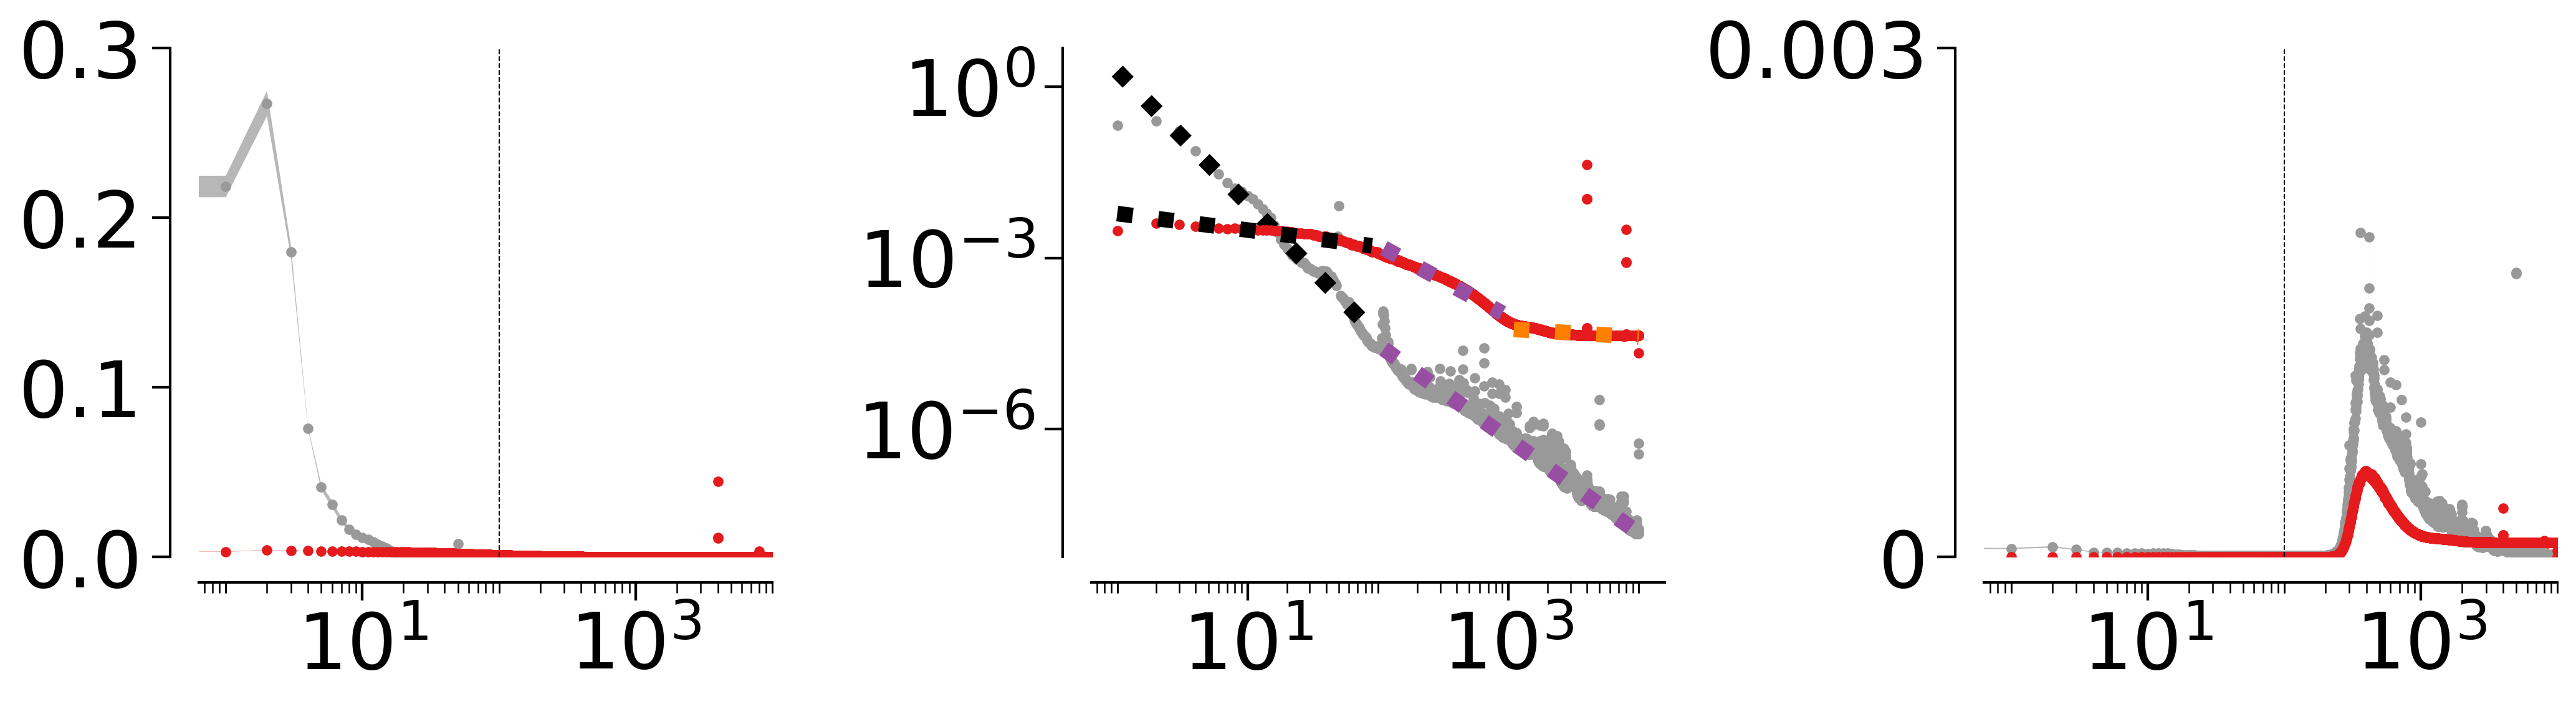

In [49]:
fig, axes = plt.subplots(1, 3, figsize=FIG_SIZE, dpi=300)

# Raw panel (8 secs) --------------------------------

# VIVO
pm = {
    "linestyle": "none",
    "marker": "o",
    "markersize": SIZE,
    "rasterized": True,
}

# 3 secs
axes[0].plot(
    out_raw_vivo["freq"], psd_mean_raw_vivo, label="vivo", color=COLOR_VIVO, **pm
)
axes[0].plot(
    out_raw_sili["freq"], psd_mean_raw_sili, color=COLOR_SILI, label="silico", **pm
)

# confidence interval
axes[0].fill_between(
    out_raw_vivo["freq"],
    (psd_mean_raw_vivo - ci_raw_vivo),
    (psd_mean_raw_vivo + ci_raw_vivo),
    color=COLOR_VIVO,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
axes[0].fill_between(
    out_raw_sili["freq"],
    (psd_mean_raw_sili - ci_raw_sili),
    (psd_mean_raw_sili + ci_raw_sili),
    color=COLOR_SILI,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)

# STATS: mark pvalues < 0.05
# x = out_raw_vivo["freq"][np.where(pvalues005_raw == 1)[0]]
# y = pvalues005_raw[np.where(pvalues005_raw == 1)[0]] * YLIM_R[1]
# axes[0].plot(x, y, "k.", markersize=1, rasterized=True)

# 100 Hz (LFP)
axes[0].vlines(
    x=100, ymin=YLIM_R[0], ymax=YLIM_R[1], linestyle="--", color="k", linewidth=0.5
)

# legend
axes[0].set_xscale("log")

# axes[0].set_xlabel("frequency [Hz]")
# axes[0].set_ylabel("Power ($\mu V^2$/Hz)")
axes[0].spines[["right", "top"]].set_visible(False)
axes[0].tick_params(axis="x", which="minor", colors="black")
axes[0].tick_params(axis="x", which="major", colors="black")

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[0].tick_params(which="both")
axes[0].xaxis.set_major_locator(locmaj)
axes[0].xaxis.set_minor_locator(locmin)
axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# disconnect axes (R style)
axes[0].spines["bottom"].set_position(("axes", -0.05))
axes[0].yaxis.set_ticks_position("left")
axes[0].spines["left"].set_position(("axes", -0.05))
axes[0].set_ylim(YLIM_R)
axes[0].set_xlim([0, SFREQ_S / 2])

# Fit panel ************************************************************

plot_fits_all(axes[1], out_raw_vivo, out_raw_sili, pm)

# Preprocessed panel ************************************************************

axes[2].plot(
    out_prep_vivo["freq"],
    psd_mean_prep_vivo,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=COLOR_VIVO,
    label="vivo",
    rasterized=True,
)
axes[2].plot(
    out_prep_sili["freq"],
    psd_mean_prep_sili,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=COLOR_SILI,
    label="silico",
    rasterized=True,
)

# confidence interval
axes[2].fill_between(
    out_prep_vivo["freq"],
    (psd_mean_prep_vivo - ci_prep_vivo),
    (psd_mean_prep_vivo + ci_prep_vivo),
    color=COLOR_VIVO,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
axes[2].fill_between(
    out_prep_sili["freq"],
    (psd_mean_prep_sili - ci_prep_sili),
    (psd_mean_prep_sili + ci_prep_sili),
    color=COLOR_SILI,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)

# mark pvalues < 0.05
# x = out_prep_vivo["freq"][np.where(pvalues005_prep == 1)[0]]
# y = pvalues005_prep[np.where(pvalues005_prep == 1)[0]] * YLIM_P[1]
# axes[2].plot(x, y, "k.", markersize=1, rasterized=True)

# 100 Hz (LFP)
axes[2].vlines(
    x=100, ymin=YLIM_P[0], ymax=YLIM_P[1], linestyle="--", color="k", linewidth=0.5
)

# legend
axes[2].set_xscale("log")
axes[2].spines[["right", "top"]].set_visible(False)
axes[2].legend(**legend_cfg)

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[2].tick_params(which="both")
axes[2].xaxis.set_major_locator(locmaj)
axes[2].xaxis.set_minor_locator(locmin)
axes[2].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# disconnect x,y axes
axes[2].spines["bottom"].set_position(("axes", -0.05))
axes[2].yaxis.set_ticks_position("left")
axes[2].spines["left"].set_position(("axes", -0.05))
axes[2].set_ylim(YLIM_P)
axes[2].set_xlim([0, SFREQ_S / 2])
axes[2].set_yticks([0, YLIM_P[1]], [0, YLIM_P[1]])

# tight
fig.tight_layout(**tight_layout_cfg)

# clear legend
axes[2].get_legend().remove()

# save (12MB figure)
# plt.savefig("figures/2_realism/4_power/svg/horvath/psd_all.svg", **savefig_cfg)

#### plot layer 1 (No layer 1 on probe 2)

#### plot layer 2/3

mean alpha: -2.1911445117864123
std alpha: 0.01285720224516626
n= 8
mean alpha: -1.6974375098658006
std alpha: 0.057652548316932166
n= 8

SILICO

mean alpha: -0.20945195146018908
std alpha: 0.024111521796719673
n= 8
mean alpha: -1.2119050051293894
std alpha: 0.15562437141571658
n= 8
mean alpha: -0.030194908690146828
std alpha: 0.024817942242290485
n= 8
2024-06-13 12:53:26,261 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


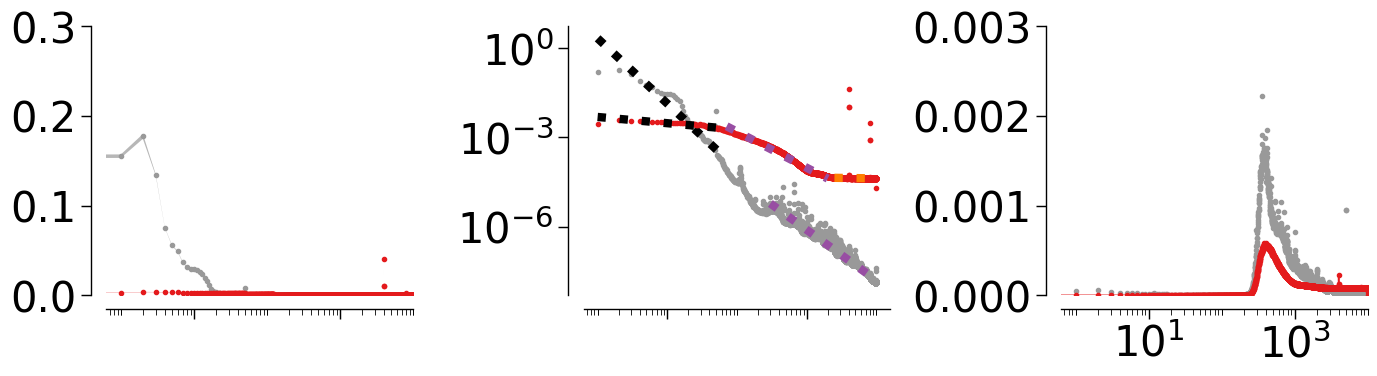

In [13]:
layer = "L2_3"

# compute data
(
    psd_mean_raw_vivo_L2,
    psd_mean_raw_sili_L2,
    psd_mean_prep_vivo_L2,
    psd_mean_prep_sili_L2,
    ci_raw_vivo_L2,
    ci_raw_sili_L2,
    ci_prep_vivo_L2,
    ci_prep_sili_L2,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
) = get_psd_plot_mean_and_ci_for_layer(
    layer,
    site_layers_vivo,
    site_layers_sili,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
)

# plot
axes = plot_for_layer(
    psd_mean_raw_vivo_L2,
    psd_mean_raw_sili_L2,
    psd_mean_prep_vivo_L2,
    psd_mean_prep_sili_L2,
    ci_raw_vivo_L2,
    ci_prep_vivo_L2,
    ci_raw_sili_L2,
    ci_prep_sili_L2,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
    site_layers_vivo,
    site_layers_sili,
    layer,
    ylim_r=YLIM_R,
    ylim_p=YLIM_P,
)

axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

# save
plt.savefig("figures/2_realism/4_power/svg/horvath/psd_l23.svg", **savefig_cfg)

#### plot layer 4

mean alpha: -2.1852805752428166
std alpha: 0.011282403937466223
n= 20
mean alpha: -1.6068685557158708
std alpha: 0.09041345803805924
n= 20
mean alpha: -0.22536746976904537
std alpha: 0.030625925457698624
n= 32
mean alpha: -1.1127200620381608
std alpha: 0.16511645449095064
n= 32
mean alpha: -0.04460699759240443
std alpha: 0.08168810185693434
n= 32
2024-06-09 14:03:37,153 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


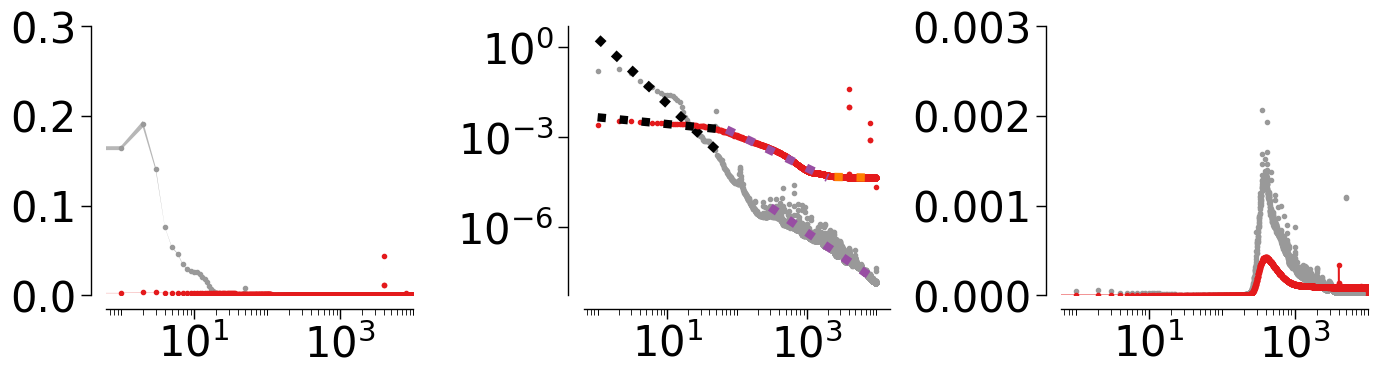

In [101]:
layer = "L4"

# compute data
(
    psd_mean_raw_vivo_L4,
    psd_mean_raw_sili_L4,
    psd_mean_prep_vivo_L4,
    psd_mean_prep_sili_L4,
    ci_raw_vivo_L4,
    ci_raw_sili_L4,
    ci_prep_vivo_L4,
    ci_prep_sili_L4,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
) = get_psd_plot_mean_and_ci_for_layer(
    layer,
    site_layers_vivo,
    site_layers_sili,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
)

# plot
axes = plot_for_layer(
    psd_mean_raw_vivo_L4,
    psd_mean_raw_sili_L4,
    psd_mean_prep_vivo_L4,
    psd_mean_prep_sili_L4,
    ci_raw_vivo_L4,
    ci_prep_vivo_L4,
    ci_raw_sili_L4,
    ci_prep_sili_L4,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
    site_layers_vivo,
    site_layers_sili,
    layer,
    ylim_r=YLIM_R,
    ylim_p=YLIM_P,
)

# save
plt.savefig("figures/2_realism/4_power/svg/horvath/psd_l4.svg", **savefig_cfg)

#### plot layer 5

mean alpha: -2.1032882907103545
std alpha: 0.08707251509650041
n= 88
mean alpha: -1.7089382252679144
std alpha: 0.19228843251308914
n= 88
mean alpha: -0.23346596233059713
std alpha: 0.015555895160639892
n= 88
mean alpha: -1.2010270016964697
std alpha: 0.1228551037352807
n= 88
mean alpha: -0.03623238152806157
std alpha: 0.07754440049166976
n= 88
mean alpha: 0.31888099307276624
std alpha: 0.11895032227182545
n= 384
mean alpha: -0.9636730776125612
std alpha: 0.1199238514860082
n= 384
2024-06-09 14:03:42,041 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


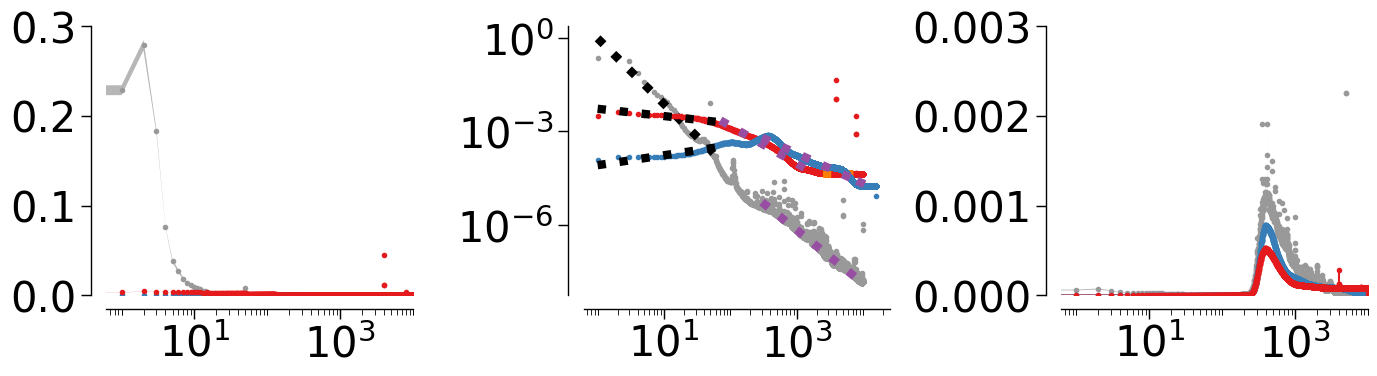

In [102]:
(
    psd_mean_raw_vivo,
    psd_mean_raw_sili,
    psd_mean_raw_b,
    psd_mean_prep_vivo,
    psd_mean_prep_sili,
    psd_mean_prep_b,
    ci_raw_vivo,
    ci_raw_sili,
    ci_raw_b,
    ci_prep_vivo,
    ci_prep_sili,
    ci_prep_b,
    freq_raw_v,
    freq_raw_s,
    freq_raw_b,
    freq_prep_v,
    freq_prep_s,
    freq_prep_b,
) = get_psd_plot_mean_and_ci_for_layer_5(
    site_layers_vivo,
    site_layers_sili,
    out_raw_vivo,
    out_raw_sili,
    out_raw_b,
    out_prep_vivo,
    out_prep_sili,
    out_prep_b,
)

# plot
plot_for_layer_5(
    psd_mean_raw_vivo,
    psd_mean_raw_sili,
    psd_mean_raw_b,
    psd_mean_prep_vivo,
    psd_mean_prep_sili,
    psd_mean_prep_b,
    ci_raw_vivo,
    ci_raw_sili,
    ci_raw_b,
    ci_prep_vivo,
    ci_prep_sili,
    ci_prep_b,
    freq_raw_v,
    freq_raw_s,
    freq_raw_b,
    freq_prep_v,
    freq_prep_s,
    freq_prep_b,
    out_raw_vivo,
    out_raw_sili,
    out_raw_b,
    site_layers_vivo,
    site_layers_sili,
    ylim_r=YLIM_R,
    ylim_p=YLIM_P,
)

plt.savefig("figures/2_realism/4_power/svg/horvath/psd_ly5.svg", **savefig_cfg)

#### plot layer 6 (None on probe 2)

# references

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)
